In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 

INPUT_FOLDER = '/media/corpora/cancer/data/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print (patients)


IMG_SIZE_PX = 40
SLICE_COUNT = 20

/usr/local/lib/python3.4/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


['00cba091fa4ad62cc3200a657aeb957e', '0a099f2549429d29b32f349e95fb2244', '0a0c32c9e08cc2ea76a71649de56be6d', '0a38e7597ca26f9374f8ea2770ba870d', '0acbebb8d463b4b9ca88cf38431aac69', '0b20184e0cd497028bdd155d9fb42dc9', '0bd0e3056cbf23a1cb7f0f0b18446068', '0c0de3749d4fe175b7a5098b060982a1', '0c37613214faddf8701ca41e6d43f56e', '0c59313f52304e25d5a7dcf9877633b1', '0c60f4b87afcb3e2dfa65abbbf3ef2f9', '0c98fcb55e3f36d0c2b6507f62f4c5f1', '0c9d8314f9c69840e25febabb1229fa4', '0ca943d821204ceb089510f836a367fd', '0d06d764d3c07572074d468b4cff954f', '0d19f1c627df49eb223771c28548350e', '0d2fcf787026fece4e57be167d079383', '0d941a3ad6c889ac451caf89c46cb92a', '0ddeb08e9c97227853422bd71a2a695e', '0de72529c30fe642bc60dcb75c87f6bd']


In [2]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [22]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
        #image[slice_number]=normalize(zero_center(image[slice_number]))
        #Revisar esto para saber cómo funciona
    return np.array(image, dtype=np.int16)

"""
Created on Tue Mar  7 12:33:50 2017

@author: juan
"""

import naturalCubicSpline as spline
import numericalIntegral

sample = (-1000, -701,-600,-500,-400,-299,100, 3000,5000)
evaluationPoints = numericalIntegral.evaluationPoint(sample,0.5)
functionValues = (-1000,-701,-700,-500,-300,-299,100,3000, 5000)
derivatives = spline.Derivatives(sample, functionValues)
coeficientsList = []

x = 0.0 #Valor a Calcular
print(evaluationPoints)
for x in evaluationPoints:
    closest = spline.closestIntervalIndex(x, sample)
    x_j = sample[closest]
    x_j_1 = sample[closest + 1]
    f_x_j = functionValues[closest]
    f_x_j_1 = functionValues[closest + 1]
    f_2_x_j = derivatives[closest]
    f_2_x_j_1 = derivatives[closest + 1]
    coeficients = spline.cubicPolynomialCoeficients(x_j, x_j_1, f_x_j, f_x_j_1, f_2_x_j, f_2_x_j_1)
    coeficientsList.append(coeficients)

print(coeficientsList)

#salida = spline.polynomialFromCoeficients(x, coeficientsList[spline.closestIntervalIndex])

def g(x):
    return spline.polynomialFromCoeficients(x, coeficientsList[spline.closestIntervalIndex(x,sample)])


#import naturalCubicSpline as spline
#sample =  (0,10)
#functionSample = (0,1)

#derivatives = spline.Derivatives(sample, functionSample)

#def g(x):
#    return spline.naturalCubicSpline(x, sample, functionSample,derivatives)
    #return 1
values_juan={}
for i in range(-1000,3001):
    values_juan[i]=g(i)


    
def g_(i):
    if i <-1000:
        i=-1000
    if i>0:
        return i
    return values_juan[i]
    
def get_pixels_juan(slices):
    vfunc = np.vectorize(g_)
    slices=vfunc(slices)
    return slices


    

#b = np.array([[8,1,7], [4,3,9], [5,2,6]])
#vecfun = np.vectorize(g)
#result = vecfun(b)
#print (result)

(-850.5, -650.5, -550.0, -450.0, -349.5, -99.5, 1550.0, 4000.0)
[array([ -9.22713545e+03,  -2.84932141e+01,  -3.03991179e-02,
        -1.01330393e-05]), array([  2.33675466e+04,   1.09206069e+02,   1.64754684e-01,
         8.26647741e-05]), array([ -5.92633587e+03,  -3.75828929e+01,  -8.01598780e-02,
        -5.33988713e-05]), array([ -5.77240819e+03,  -3.66593268e+01,  -7.83127458e-02,
        -5.21674498e-05]), array([  2.55817087e+03,   2.61390710e+01,   7.90820673e-02,
         7.89948944e-05]), array([ -1.96649287e+02,   2.37934415e+00,   6.10741098e-03,
        -2.35923747e-06]), array([ -1.32935637e+04,   1.33040591e+02,   1.07258739e-02,
        -1.77541139e-05]), array([ -3.85857014e+06,   3.68155695e+03,  -1.12265288e+00,
         1.08176858e-04])]


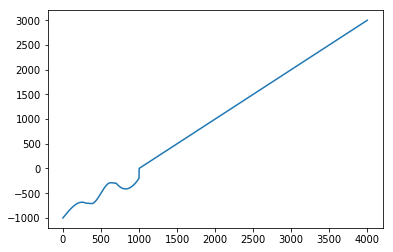

In [23]:
juan_data=[]
for i in range(-1000,3000):
    juan_data.append(g_(i))
    
plt.plot(juan_data)
plt.show()

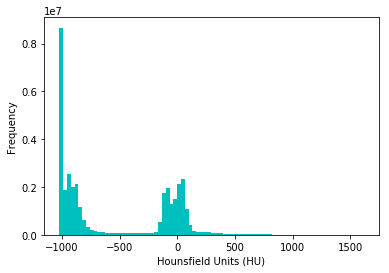

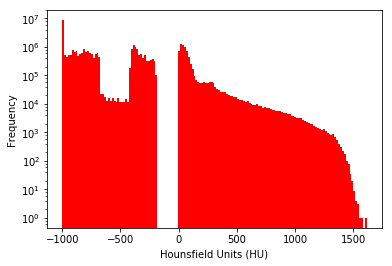

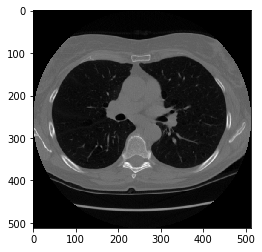

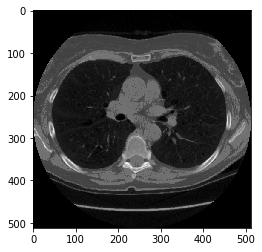

In [27]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

first_patient_pixels_juan = get_pixels_juan(first_patient_pixels)
plt.hist(first_patient_pixels_juan.flatten(), bins=160, color='r',log=True )
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

# Show juan transformation
first_patient_pixels_juan = get_pixels_juan(first_patient_pixels)
plt.imshow(first_patient_pixels_juan[80], cmap=plt.cm.gray)
plt.show()

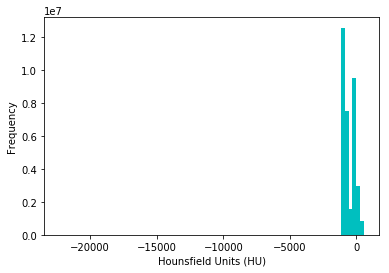

In [48]:
plt.imshow(first_patient_pixels_juan[80]-first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

NameError: name 'first_patient_pixels_juan' is not defined

In [49]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    image.resize((SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX))
    return image, new_spacing

In [50]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [10,5,5])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (20, 40, 40)


In [28]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

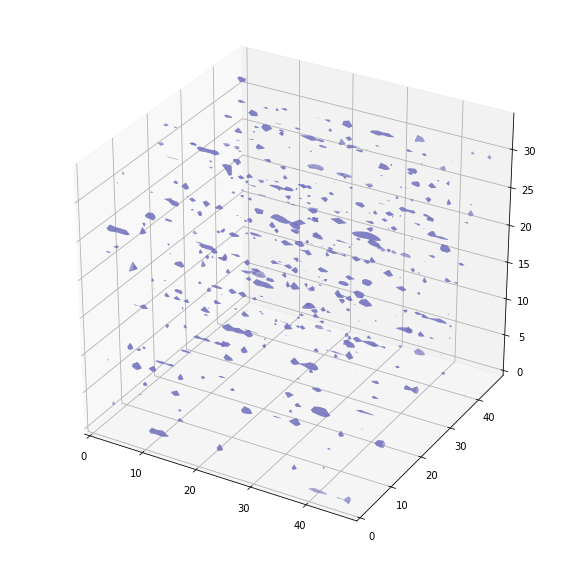

In [29]:
plot_3d(pix_resampled, 400)

In [30]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [31]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

In [32]:
plot_3d(segmented_lungs, 0)

IndexError: arrays used as indices must be of integer (or boolean) type

In [33]:
plot_3d(segmented_lungs_fill, 0)

IndexError: arrays used as indices must be of integer (or boolean) type

In [34]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

IndexError: arrays used as indices must be of integer (or boolean) type

In [51]:
labels = pd.read_csv('/media/corpora/cancer/stage1_labels.csv', index_col=0)

much_data = []
for num,patient in enumerate(patients):
    if num % 1 == 0:
        print(num,patient)
    try:
        label = labels.get_value(patient, 'cancer')
        print (label)
        patient = load_scan(INPUT_FOLDER + patient)
        patient_pixels = get_pixels_hu(patient)
        pix_resampled, spacing = resample(patient_pixels, patient, [10,5,5])
        segmented_lungs = segment_lung_mask(pix_resampled, False)
        segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

        #img_data,label = process_data(patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        if label == 1: label=np.array([0,1])
        elif label == 0: label=np.array([1,0])
        
        much_data.append([segmented_lungs_fill,label])
    except KeyError as e:
        print('This is unlabeled data!')

#np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)
np.save('muchdata.npy', much_data)

0 00cba091fa4ad62cc3200a657aeb957e
0
1 0a099f2549429d29b32f349e95fb2244
0
2 0a0c32c9e08cc2ea76a71649de56be6d
0
3 0a38e7597ca26f9374f8ea2770ba870d
0


/usr/local/lib/python3.4/dist-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


4 0acbebb8d463b4b9ca88cf38431aac69
1
5 0b20184e0cd497028bdd155d9fb42dc9
This is unlabeled data!
6 0bd0e3056cbf23a1cb7f0f0b18446068
0
7 0c0de3749d4fe175b7a5098b060982a1
1
8 0c37613214faddf8701ca41e6d43f56e
1
9 0c59313f52304e25d5a7dcf9877633b1
0
10 0c60f4b87afcb3e2dfa65abbbf3ef2f9
1
11 0c98fcb55e3f36d0c2b6507f62f4c5f1
0
12 0c9d8314f9c69840e25febabb1229fa4
0
13 0ca943d821204ceb089510f836a367fd
0
14 0d06d764d3c07572074d468b4cff954f
1
15 0d19f1c627df49eb223771c28548350e
0
16 0d2fcf787026fece4e57be167d079383
0
17 0d941a3ad6c889ac451caf89c46cb92a
0
18 0ddeb08e9c97227853422bd71a2a695e
0
19 0de72529c30fe642bc60dcb75c87f6bd
0


In [52]:
import tensorflow as tf
import numpy as np


n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

In [53]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

In [54]:
VAL_MAGIC=41472
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,32])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([VAL_MAGIC ,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([32])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)

    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, VAL_MAGIC ])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [55]:
much_data = np.load('muchdata.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:18]
validation_data = much_data[18:]
for data in much_data:
    print(data[0].shape)


def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits( logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 100
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            #print (epoch)
            #print (train_data.shape)
            for data in train_data:
                    total_runs += 1
                    #try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                    '''except Exception as e:
                        # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                        # input tensor. Not sure why, will have to look into it. Guessing it's
                        # one of the depths that doesn't come to 20.
                        pass
                        #print(str(e))'''
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            #print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        #print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)

# Run this locally:
train_neural_network(x)

(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
(20, 40, 40)
Instructions for updating:
Use `tf.global_variables_initializer` instead.


InvalidArgumentError: Input to reshape is a tensor with 16000 values, but the requested shape requires a multiple of 41472
	 [[Node: Reshape_51 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](MaxPool3D_21, Reshape_51/shape)]]
	 [[Node: Mean_50/_15 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_293_Mean_50", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Reshape_51', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.4/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.4/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-4ce7a05d7181>", line 53, in <module>
    train_neural_network(x)
  File "<ipython-input-55-4ce7a05d7181>", line 10, in train_neural_network
    prediction = convolutional_neural_network(x)
  File "<ipython-input-54-5990ee208e11>", line 25, in convolutional_neural_network
    fc = tf.reshape(conv2,[-1, VAL_MAGIC ])
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2630, in reshape
    name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 16000 values, but the requested shape requires a multiple of 41472
	 [[Node: Reshape_51 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](MaxPool3D_21, Reshape_51/shape)]]
	 [[Node: Mean_50/_15 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_293_Mean_50", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
